## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import lightning.pytorch as pl
from torchsummary import summary
from torchmetrics import Accuracy
import itertools
import random
import cv2
print(torch.__version__)

2.0.1


## Hyperparameters

In [2]:
learning_rate = 1e-02
batch_size = 256
epochs = 40
img_size = (33,33)
train_size = 0.8
num_classes = 1000

## Downloading and Loading Data

In [3]:
class Cifar10Dataset(Dataset):
    def __init__(self, images, permutations, transforms = None):
        self.images = images
        self.transforms = transforms
        self.permutations = permutations

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transforms:
            img = self.transforms(img)
        orig_img = img
        # Generating patches
        patches = []
        for i in range(9):
            row, col = i//3, i%3
            row_start, row_end = row*11, row*11+11
            col_start, col_end = col*11, col*11+11
            patches.append(orig_img[:, row_start:row_end, col_start:col_end])
        perm_idx = np.random.randint(len(self.permutations))
        perm = self.permutations[perm_idx]
        patches = [patches[idx] for idx in perm]
        permuted_img = np.zeros_like(orig_img)
        for i in range(9):
            row, col = i//3, i%3
            row_start, row_end = row*11, row*11+11
            col_start, col_end = col*11, col*11+11
            permuted_img[:, row_start:row_end, col_start:col_end] = patches[i]
            patches[i] = patches[i].unsqueeze(0)

        patches = torch.cat(patches, 0)
        return orig_img, permuted_img, patches, perm_idx

In [4]:
cifar10_train = datasets.CIFAR10('./data/', train=True, transform=None)
all_permutations = list(itertools.permutations([0,1,2,3,4,5,6,7,8]))
random.shuffle(all_permutations)
all_permutations = all_permutations[:num_classes] # Selecting 1000 random permutations
cifar10_test = datasets.CIFAR10('./data', train=False)

In [5]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor()
])

all_idxs = np.arange(len(cifar10_train))
random.shuffle(all_idxs)
train_idxs = all_idxs[:int(train_size*len(all_idxs))]
valid_idxs = all_idxs[int(train_size*len(all_idxs)):]


train_dataset = Cifar10Dataset(cifar10_train.data[train_idxs], all_permutations, train_transforms)
valid_dataset = Cifar10Dataset(cifar10_train.data[valid_idxs], all_permutations, valid_transforms)
test_dataset = Cifar10Dataset(cifar10_test.data, all_permutations, test_transforms)
trainloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

## Visualizing Data

In [6]:
def images_visualization(orig_images, permuted_image, title1, title2):
    fig, axes = plt.subplots(nrows=8, ncols=17, figsize=(17,8))
    orig_images = orig_images[:64]
    permuted_image = permuted_image[:64]
    for idx, (img1, img2) in enumerate(zip(orig_images, permuted_image)):
        row_num = idx // 8
        col_num1 = idx % 8
        col_num2 = idx % 8 + 9

        # Display the first set of kernels
        if img1.ndim == 3:
            axes[row_num][col_num1].imshow(img1.permute(1,2,0))
        else:
            axes[row_num][col_num1].imshow(img1, cmap = 'gray')
        axes[row_num][col_num1].axis('off')
        
        # Display the second set of kernels
        if img2.ndim == 3:
            axes[row_num][col_num2].imshow(img2.permute(1,2,0))
        else:
            axes[row_num][col_num2].imshow(img2, cmap = 'gray')
        axes[row_num][col_num2].axis('off')

    for row_num in range(8):
        axes[row_num][8].axis('off')
        
    # Add titles for the first and second set of kernels
    axes[0][3].set_title(title1,fontsize=20)
    axes[0][12].set_title(title2,fontsize=20)

    plt.tight_layout()
    plt.show()

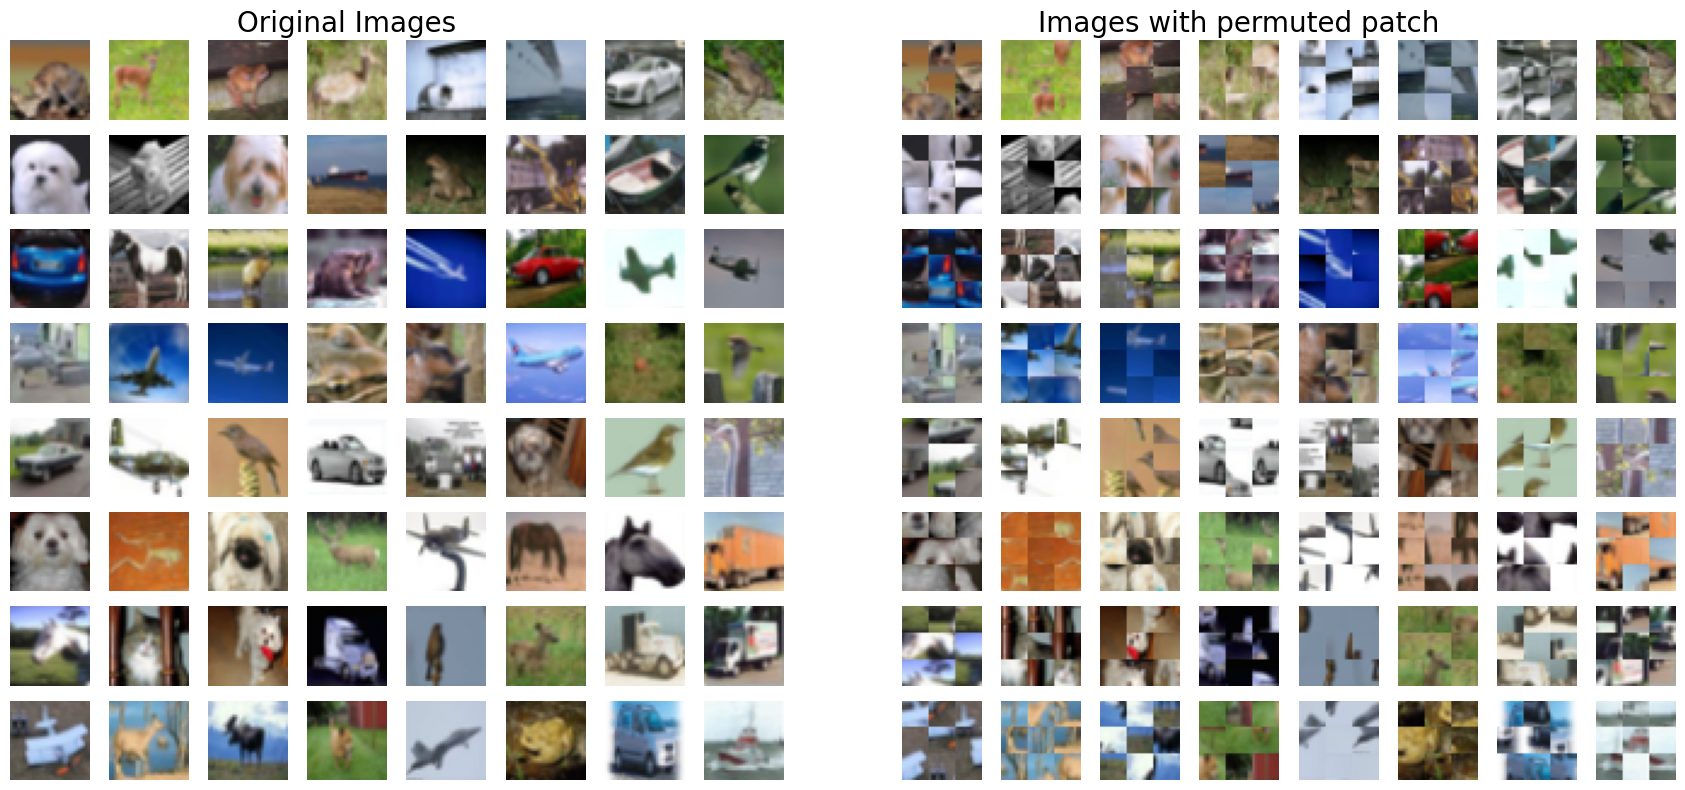

In [7]:
orig_img, permuted_img, patches, perm_idx = next(iter(trainloader))
images_visualization(orig_img, permuted_img, "Original Images", "Images with permuted patch")

## Model Building


In [8]:
class JigsawModel(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.generate_model(num_classes)
        self.loss_fxn()
        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)

    def training_step(self, batch, batch_idx):
        _, _, patches, perm_idx = batch
        preds = self(patches)
        loss = self.criterion(preds, perm_idx)
        train_acc = self.accuracy(preds, perm_idx)
        self.log_dict({'Train_loss': loss, 'train_acc': train_acc}, on_step = False, on_epoch = True, prog_bar = True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        _, _, patches, perm_idx = batch
        preds = self(patches)
        val_loss = self.criterion(preds, perm_idx)
        val_acc = self.accuracy(preds, perm_idx)
        self.log_dict({'Valid_loss': val_loss, 'valid_acc': val_acc}, on_step = False, on_epoch = True, prog_bar = True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        _, _, patches, perm_idx = batch
        preds = self(patches)
        test_loss = self.criterion(preds, perm_idx)
        test_acc = self.accuracy(preds, perm_idx)
        self.log_dict({"Test_loss": test_loss, 'test_acc': test_acc}, on_step = False, on_epoch = True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = 1e-02)
        return optimizer

    def loss_fxn(self):
        self.criterion = nn.CrossEntropyLoss()

    def generate_model(self, num_classes):
        self.featureExtractor = nn.Sequential(self.conv_block(3, 32, 3, 1, 1),
                                              self.conv_block(32, 64, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              self.conv_block(64, 64, 3, 1, 1),
                                              self.conv_block(64, 128, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              self.conv_block(128, 128, 3, 1, 1),
                                              self.conv_block(128, 256, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              nn.Flatten()
                                              )
        self.output = nn.Sequential(nn.Dropout(p = 0.5),
                                    nn.Linear(256*9, 2048), # 9 since that is the number of patches
                                    nn.BatchNorm1d(num_features=2048),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(2048, num_classes)
                                   )
        self.output.apply(self.init_weights)

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                            nn.BatchNorm2d(num_features=out_channels),
                            nn.ReLU(inplace=True),
                            )
        block.apply(self.init_weights)
        return block

    def init_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            torch.nn.init.xavier_normal_(layer.weight)
        elif isinstance(layer, nn.Linear):
            torch.nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.0)

    def forward(self, x):
        batch, patches, channels, height, width = x.shape
        x = x.transpose(0,1)
        features = []
        for patch_idx in range(patches):
            curr_patch = x[patch_idx]
            curr_patch_features = self.featureExtractor(curr_patch)
            features.append(curr_patch_features)

        features = torch.cat(features, dim = -1)
        out = self.output(features)
        return out

## Training the model

In [ ]:
torch.set_float32_matmul_precision('medium')
jigsaw_model = JigsawModel(len(all_permutations))
trainer = pl.Trainer(max_epochs = epochs, log_every_n_steps=10)
trainer.fit(jigsaw_model, trainloader, validloader)

In [10]:
metric = pd.read_csv('lightning_logs/version_0/metrics.csv')
metric.head()

epoch  valid_acc  step  Valid_loss  train_acc  Train_loss
0      0     0.0045   156    6.853939        NaN         NaN
1      0        NaN   156         NaN      0.002    7.880759
2      1     0.0297   313    6.113683        NaN         NaN
3      1        NaN   313         NaN      0.013    6.567956
4      2     0.0679   470    5.345274        NaN         NaN

In [11]:
valid_losses = metric[~metric['Valid_loss'].isna()]['Valid_loss'].values
train_losses = metric[~metric['Train_loss'].isna()]['Train_loss'].values
valid_accuracy = metric[~metric['valid_acc'].isna()]['valid_acc'].values
train_accuracy = metric[~metric['train_acc'].isna()]['train_acc'].values

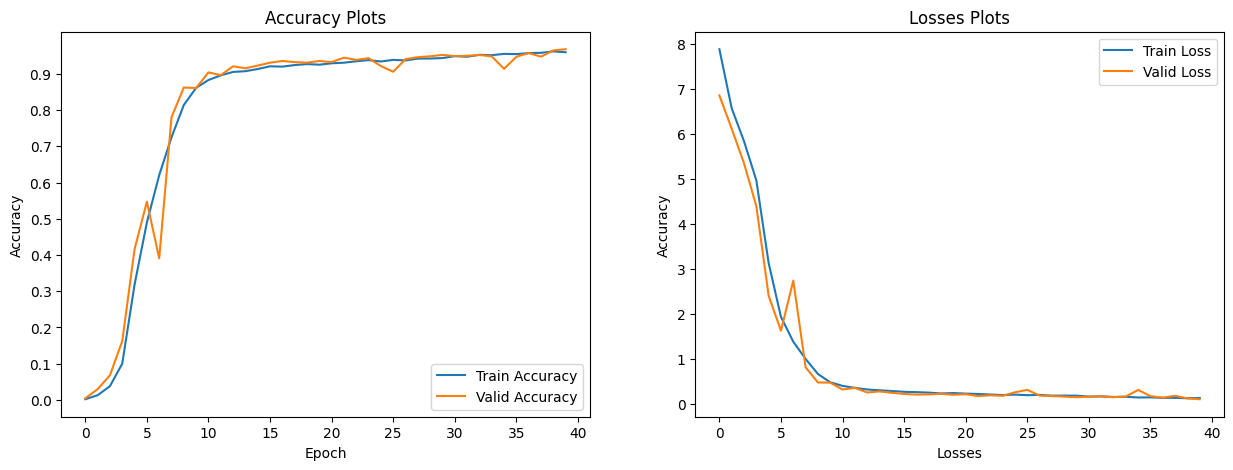

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(train_accuracy, label="Train Accuracy")
axes[0].plot(valid_accuracy, label="Valid Accuracy")
axes[0].set_title('Accuracy Plots')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_yticks(np.arange(0.0, 1.0, 0.1))
axes[0].legend()

axes[1].plot(train_losses, label="Train Loss")
axes[1].plot(valid_losses, label="Valid Loss")
axes[1].set_title('Losses Plots')
axes[1].set_xlabel('Losses')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()

## Final Results

In [13]:
trainer.test(jigsaw_model, dataloaders=testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test_loss           0.10485484451055527
        test_acc            0.9684000015258789
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Test_loss': 0.10485484451055527, 'test_acc': 0.9684000015258789}]

In [14]:
def rejumble_jigsaw(patches, perm_idx):
    current_perm = all_permutations[perm_idx]
    rejumbled_img = torch.zeros((3,33,33))
    for i in range(9):
        row, col = current_perm[i]//3, current_perm[i]%3
        row_start, row_end = row*11, row*11+11
        col_start, col_end = col*11, col*11+11
        rejumbled_img[:, row_start:row_end, col_start:col_end] = patches[i].detach().cpu()
    return rejumbled_img

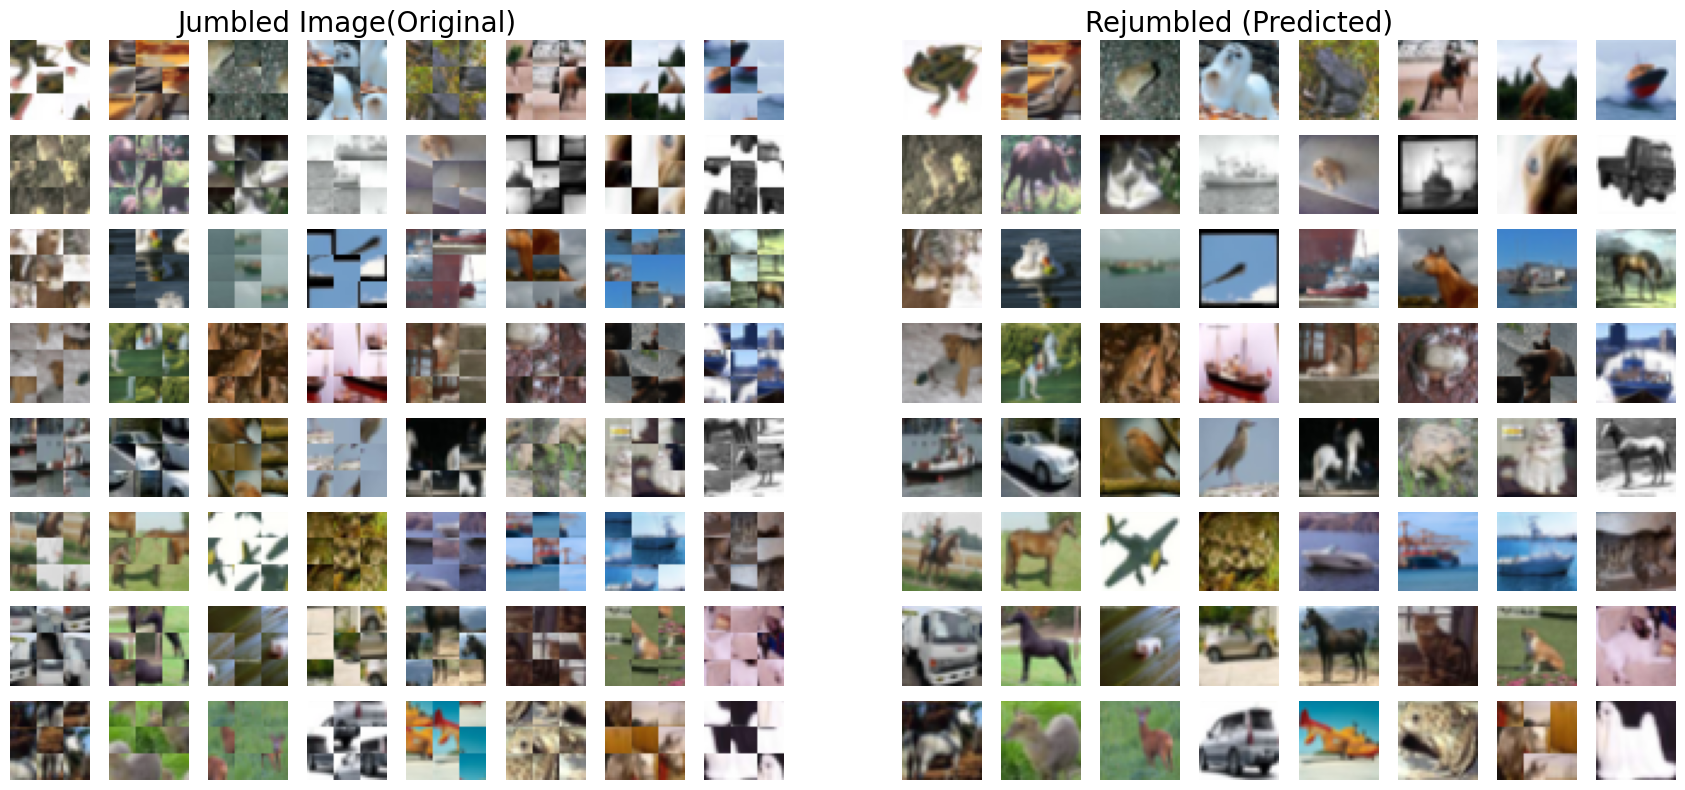

In [16]:
orig_img, permuted_img, patches, perm_idx = next(iter(validloader))
predictions = torch.max(jigsaw_model(patches), axis = -1)[1]
rejumbled_images = torch.zeros_like(orig_img)
for i in range(len(orig_img)):
    rejumbled_images[i] = rejumble_jigsaw(patches[i], predictions[i])
images_visualization(permuted_img, rejumbled_images, 'Jumbled Image(Original)', 'Rejumbled (Predicted)')

## Downstream Task (Cifar 10 Classification)

In [17]:
train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])
cifar10_train = datasets.CIFAR10('./data/', train=True, transform=train_transforms)
cifar10_test = datasets.CIFAR10('./data', train=False, transform=test_transforms)

In [18]:
train_loader = DataLoader(cifar10_train, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, num_workers=2)

In [19]:
class ClassificationModel(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.generate_model(num_classes)
        self.loss_fxn()
        self.freeze()
        self.accuracy = Accuracy(task='multiclass', num_classes=10)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.reshape(-1,)
        preds = self(images)
        loss = self.criterion(preds, labels)
        train_acc = self.accuracy(preds, labels)
        self.log_dict({'Train_loss': loss, 'train_acc': train_acc}, on_step = False, on_epoch = True, prog_bar = True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.reshape(-1,)
        preds = self(images)
        val_loss = self.criterion(preds, labels)
        val_acc = self.accuracy(preds, labels)
        self.log_dict({'Valid_loss': val_loss, 'valid_acc': val_acc}, on_step = False, on_epoch = True, prog_bar = True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.reshape(-1,)
        preds = self(images)
        test_loss = self.criterion(preds, labels)
        test_acc = self.accuracy(preds, labels)
        self.log_dict({"Test_loss": test_loss, 'test_acc': test_acc}, on_step = False, on_epoch = True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = 1e-02)
        return optimizer

    def loss_fxn(self):
        self.criterion = nn.CrossEntropyLoss()

    def generate_model(self, num_classes):
        self.featureExtractor = nn.Sequential(self.conv_block(3, 32, 3, 1, 1),
                                              self.conv_block(32, 64, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              self.conv_block(64, 64, 3, 1, 1),
                                              self.conv_block(64, 128, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              self.conv_block(128, 128, 3, 1, 1),
                                              self.conv_block(128, 256, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              nn.Flatten()
                                              )
        self.output = nn.Sequential(nn.Dropout(p = 0.5),
                                    nn.Linear(256*9, 2048), # 9 since that is the number of patches
                                    nn.BatchNorm1d(num_features=2048),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(2048, num_classes)
                                   )
        self.output.apply(self.init_weights)

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                            nn.BatchNorm2d(num_features=out_channels),
                            nn.ReLU(inplace=True),
                            )
        block.apply(self.init_weights)
        return block

    def init_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            torch.nn.init.xavier_normal_(layer.weight)
        elif isinstance(layer, nn.Linear):
            torch.nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.0)

    def forward(self, x):
        features = self.featureExtractor(x)
        out = self.output(features)
        return out

In [21]:
classification_model = ClassificationModel(num_classes=len(all_permutations))
checkpoint = torch.load('./lightning_logs/version_0/checkpoints/epoch=39-step=6280.ckpt')
classification_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [22]:
# Removing the output with classifier
classification_model.output = nn.Sequential(nn.Dropout(p = 0.5),
                                    nn.Linear(4096, 2048),
                                    nn.BatchNorm1d(num_features=2048),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(2048, 10) # Since CIFAR 10 have 10 classes
                                   )

Training with only classifier layer unfreezed and other feature extractor layers freezed

In [23]:
epochs = 20
trainer = pl.Trainer(max_epochs = epochs, log_every_n_steps=10)
trainer.fit(classification_model, train_loader, test_loader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name             | Type               | Params
--------------------------------------------------------
0 | featureExtractor | Sequential         | 574 K 
1 | output           | Sequential         | 8.4 M 
2 | criterion        | CrossEntropyLoss   | 0     
3 | accuracy         | MulticlassAccuracy | 0     
--------------------------------------------------------
8.4 M     Trainable params
574 K     Non-trainable params
9.0 M     Total params
35.958    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [25]:
metric = pd.read_csv('lightning_logs/version_1/metrics.csv')
metric.head()

epoch  valid_acc  step  Valid_loss  train_acc  Train_loss
0      0     0.4110   195    1.655025        NaN         NaN
1      0        NaN   195         NaN    0.34232    2.053494
2      1     0.4455   391    1.551332        NaN         NaN
3      1        NaN   391         NaN    0.40918    1.672625
4      2     0.4626   587    1.521743        NaN         NaN

In [26]:
valid_losses = metric[~metric['Valid_loss'].isna()]['Valid_loss'].values
train_losses = metric[~metric['Train_loss'].isna()]['Train_loss'].values
valid_accuracy = metric[~metric['valid_acc'].isna()]['valid_acc'].values
train_accuracy = metric[~metric['train_acc'].isna()]['train_acc'].values

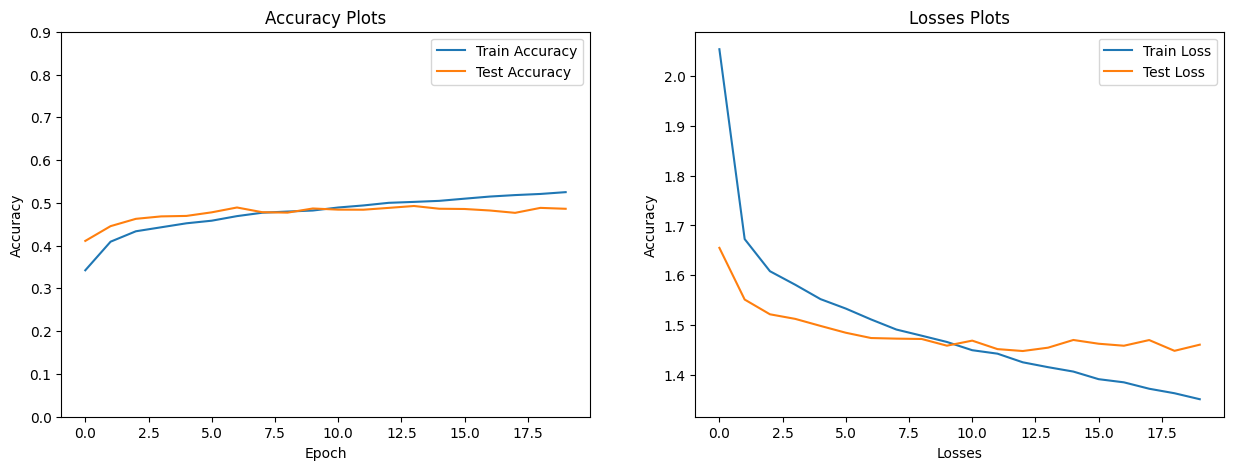

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(train_accuracy, label="Train Accuracy")
axes[0].plot(valid_accuracy, label="Test Accuracy")
axes[0].set_title('Accuracy Plots')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_yticks(np.arange(0.0, 1.0, 0.1))
axes[0].legend()

axes[1].plot(train_losses, label="Train Loss")
axes[1].plot(valid_losses, label="Test Loss")
axes[1].set_title('Losses Plots')
axes[1].set_xlabel('Losses')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()

## GradCam Visualization

In [28]:
imgs, lbls = next(iter(test_loader))

In [29]:
def gradcam_visualization(img, model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img = img.to(device)[None]
    model = model.to(device)
    model.unfreeze()
    model.eval()
    activation_network = model.featureExtractor[:-3]
    category = model(img)
    category = torch.max(category, dim = -1)[0]
    feature_maps = activation_network(img)
    model.zero_grad()
    category.backward(retain_graph = True)
    gradients_mean = model.featureExtractor[-3][0].weight.grad.data.mean((0,2,3))
    for i in range(len(gradients_mean)):
        feature_maps[:,i, :, :] *= gradients_mean[i]
    heatmap = torch.mean(feature_maps, dim = 1)[0].cpu().detach()
    heatmap = heatmap.numpy()
    min_value, max_value = heatmap.min(), heatmap.max()
    heatmap = 255*((heatmap - min_value)/(max_value - min_value))
    heatmap = heatmap.astype(np.uint8)
    img = 255*np.transpose(img[0].detach().cpu().numpy(), (1,2,0))
    heatmap = cv2.resize(heatmap, img.shape[:-1])
    heatmap = 255 - heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET).astype(np.uint8)
    heatmap = (0.3*heatmap + 0.7*img).astype(np.uint8)
    heatmap = torch.permute(torch.tensor(heatmap), (2,0,1))/255.
    return heatmap

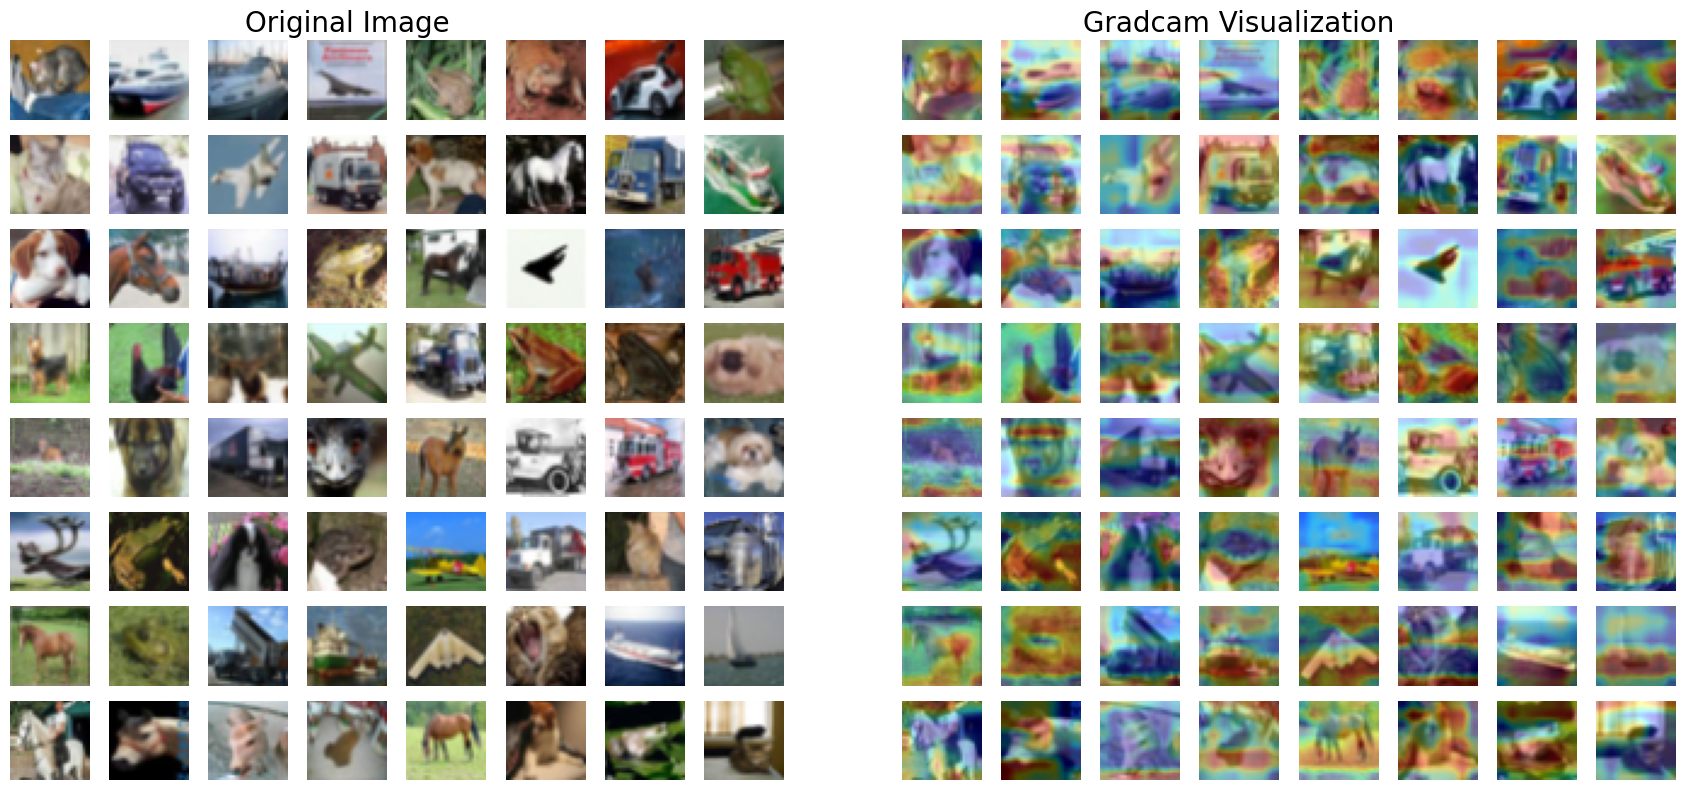

In [31]:
imgs, lbls= next(iter(test_loader))
grad_cam_images = torch.zeros_like(orig_img)
for i in range(len(orig_img)):
    grad_cam_images[i] = gradcam_visualization(imgs[i], classification_model)
images_visualization(imgs, grad_cam_images, 'Original Image', 'Gradcam Visualization')